In [9]:
import pickle
import numpy as np

In [2]:
test_data_const_demog = pickle.load(open('../data/trees/test_data.pickle','rb'))
# train_data_const_demog = pickle.load(open('../data/trees/train_data.pickle','rb'))
# test_data_two_epoch_varied = pickle.load(open('../data/trees/test_data_1B08_varied_scale_2.pickle','rb'))
# train_data_two_epoch_varied = pickle.load(open('../data/trees/train_data_1B08_varied_scale_2.pickle','rb'))

In [ ]:
list(test_data_const_demog.keys())[:10]

In [ ]:
list(train_data_const_demog.keys())[:10]

In [ ]:
list(test_data_two_epoch_varied.keys())[:10]

In [ ]:
list(train_data_two_epoch_varied.keys())[:10]

In [3]:
ts = test_data_const_demog[(0.03217024708954827, 0.1491846925468981, 0)]

In [4]:
haps = ts.genotype_matrix().T
haps

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [5]:
haps.shape

(20, 1889)

In [6]:
selection_coeffs = []

for mut in ts.mutations():
    selection_coeff = sum(
        [m.get("selection_coeff") for m in mut.metadata["mutation_list"]]
    )
    selection_coeffs.append(selection_coeff)

len(selection_coeffs)

1889

In [7]:
selection_coeffs[:10]

[0.0,
 0.0,
 0.0,
 0.0,
 -1.6856466222847644e-09,
 -4.769163410855981e-07,
 -2.3888899747248615e-08,
 -0.0013001853367313743,
 -2.8136393666500226e-05,
 0.0]

In [8]:
# get position in haps that is neutral
neu_positions = []
# for i, (_, s) in enumerate(zip(positions, selection_coeffs)):
for i, s in enumerate(selection_coeffs):
    if s == 0:
        neu_positions.append(i)
len(neu_positions)

679

In [9]:
neu_positions[:10]

[0, 1, 2, 3, 9, 10, 11, 12, 15, 17]

In [10]:
import numpy as np
matrix = np.array([
    [[1, 2], [3, 4]],
    [[5, 6], [7, 8]],
    [[9, 10], [11, 12]],
    [[13, 14], [15, 16]],
    [[17, 18], [19, 20]],
    [[21, 22], [23, 24]],
])
matrix.shape

(6, 2, 2)

In [11]:
len(matrix)

6

In [15]:
matrix_pad = np.pad(matrix, ((0,0),(0,3),(0,0)), mode='constant', constant_values=0)

In [14]:
matrix.shape

(6, 2, 2)

In [16]:
matrix_pad.shape

(6, 5, 2)

In [10]:
def ts_to_tensor(ts):
    """
    Input: a simulated tree sequence
    max_snps: cut off snps window size
    Output: a tensor representing non-syn, syn SNP vs ancestral state
    """

    # get haplotype matrix, which has 0 for ancestral and 1 for derived
    haps = ts.genotype_matrix().T

    # get selection coefficients for all snp positions (columns)
    selection_coeffs = []

    for mut in ts.mutations():
        selection_coeff = sum(
            [m.get("selection_coeff") for m in mut.metadata["mutation_list"]]
        )
        selection_coeffs.append(selection_coeff)
    # currently not using position
    # positions = [variant.site.position for variant in ts.variants()]

    # get position in haps that is neutral
    neu_positions = []
    # for i, (_, s) in enumerate(zip(positions, selection_coeffs)):
    for i, s in enumerate(selection_coeffs):
        if s == 0:
            neu_positions.append(i)

    # save position of fixed SNPs to be removed here
    fixed_positions = []
    # make two dims with the same shape and values as the haplotype matrix
    # ancestral entries of 0 will stay 0 in both dims
    # dim_1: 1 only if a position is non-syn SNP (selection coeff != 0), so need to
    # set the 1s at neutral positions to 0
    # dim_2: 1 only if a position is syn SNP (selection coeff is 0 and is a 1 in haps),
    # so need to set the 1s at non-neutral positions to 0
    dim_1, dim_2 = haps.copy(), haps.copy()

    # iterate through all SNP positions (columns) in matrix
    for idx in range(haps.shape[1]):
        # get position in haps that have fixed snp (1s in the whole column)
        if np.all(haps[:, idx] == 1):
            fixed_positions.append(idx)
        # if a neutral position, then set dim_1 value to 0 if it's currently 1 (not ancestral)
        if idx in neu_positions:
            dim_1[:, idx][np.where(haps[:, idx] == 1)] = 0
        # if not neutral position (non-syn SNP), then set dim_2 value to 0 if it's currently 1 (not ancestral)
        else:
            dim_2[:, idx][np.where(haps[:, idx] == 1)] = 0

    # stacking dim_1 and dim_2 together to make snp tensor
    snp_tensor = np.stack((dim_1, dim_2), axis=-1)

    # drop columns that are all 1s (fixed)
    new_tensor = np.delete(snp_tensor, fixed_positions, 1)
    # if have position vector in the future will have to
    # remove the fixed positions accordingly as well

    return new_tensor


tensor = ts_to_tensor(ts)

In [11]:
tensor.shape

(20, 1413, 2)

In [42]:
import numpy as np
def chunks(tensor, max_snps):
    for i in range(0, tensor.shape[1], 300):
        res = (yield tensor[:, i:i+max_snps, :])
    

In [43]:
chunks(tensor, 300)

<generator object chunks at 0x7f7b7768bd40>

In [44]:
len(list(chunks(tensor, 300)))

5

In [47]:
list(chunks(tensor, 300))[2].shape

(20, 300, 2)

In [46]:
list(chunks(matrix, 300))[0].shape

(6, 2, 2)

In [48]:
def split_long_tensor(tensor, max_snps: int):
    """
    Breaking a long tensor into more reasonable windows
    Pad a window with 0s if smalle that max_snps
    Input: a list of a single tensor to be split up
    Output: a list of broken down tensors
    """

    def _split_tensor(tensor, max_snps: int):
        for i in range(0, tensor.shape[1], 300):
            res = (yield tensor[:, i:i+max_snps, :])
    
    cropped_tensor_list = list(_split_tensor(tensor, max_snps))
    
    # padding as needed
    last_tensor = cropped_tensor_list[-1]
    if last_tensor.shape[1] < max_snps:
        # padd to the max snp size
        pad_width = max_snps - last_tensor.shape[1]
        padded_tensor = np.pad(
            last_tensor,
            ((0, 0), (0, pad_width), (0, 0)),
            mode="constant",
            constant_values=0,
        )
        # replace this tensor in the list and return
        cropped_tensor_list[-1] = padded_tensor
    
    return cropped_tensor_list

In [49]:
split_tensor_slit = split_long_tensor(tensor, 300)

In [51]:
len(split_tensor_slit)

5

In [52]:
split_tensor_slit[4].shape

(20, 300, 2)

In [53]:
split_tensor_slit[4]

array([[[0, 0],
        [0, 0],
        [0, 1],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [1, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[1, 0],
        [0, 0],
        [0, 1],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [1, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[1, 0],
        [0, 0],
        [0, 1],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=int32)

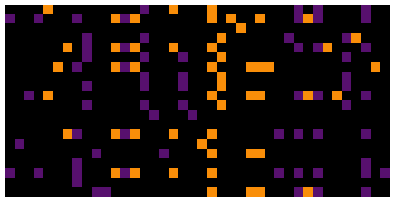

In [32]:
from matplotlib import pyplot as plt


def visualize_snp_tensor(snp_tensor, pixel_size=5):
    """Expecting input is a 3d snp tensor, where the shape is (h, w, 2)"""

    # Get SNP tensor size
    row, col, _ = snp_tensor.shape

    # Add a 3rd dimension with zeros (will be the position vector once implemented)
    dim_3 = np.zeros((row, col))
    img = np.stack((snp_tensor[:, :, 0], snp_tensor[:, :, 1], dim_3), axis=-1).astype(
        np.uint8
    )

    # convert pixel to "inferno" color scheme
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i,j,:] == np.array([1,0,0])).all():
                img[i,j,:] = np.array([249, 142, 9])
            elif (img[i,j,:] == np.array([0,1,0])).all():
                img[i,j,:] = np.array([87, 16, 110])
    # Get image size
    height, width, channels = img.shape

    # Calculate the figure size based on pixel size and image dimensions
    fig_width = pixel_size * (width / float(height))
    fig_height = pixel_size

    # Set the DPI for the figure based on desired pixel size
    dpi = 10 * pixel_size

    # Create a new figure with the adjusted size and DPI
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    # Display the image array as a grayscale image
    ax.imshow(img)

    # Remove the axis labels and ticks
    ax.axis("off")

    # Show the plot
    plt.show()
    
visualize_snp_tensor(tensor[:,:40,:])

In [27]:
tensor[0,1,:]

array([0, 0], dtype=int32)

In [29]:
np.array((249, 142, 9))

array([249, 142,   9])

In [21]:
tensor_copied = tensor.copy()

# get the non-syn and syn hap matrix
non_syn_hap = tensor_copied[:, :, 0].T
syn_hap = tensor_copied[:, :, 1].T


In [22]:
non_syn_hap.shape

(1413, 20)

In [23]:
import allel
fs_non_syn = allel.sfs(allel.HaplotypeArray(non_syn_hap).count_alleles()[:, 1])[1:]
fs_syn = allel.sfs(allel.HaplotypeArray(syn_hap).count_alleles()[:, 1])[1:]

In [24]:
fs_non_syn

array([321,  92,  62,  23,  47,  28,   9,  25,  12,  16,  14,  20,  11,
        11,   7,  12,   6,   7,  11])

In [36]:
len(fs_non_syn)

19

In [37]:
fs_non_syn.shape[0]

19

In [25]:
fs_syn

array([255,  96,  49,  34,  32,  34,  25,  22,  18,  17,  10,  15,   9,
        10,   5,   8,  13,  10,  17])

In [39]:
np.concatenate((fs_syn, np.zeros(3)))

array([255.,  96.,  49.,  34.,  32.,  34.,  25.,  22.,  18.,  17.,  10.,
        15.,   9.,  10.,   5.,   8.,  13.,  10.,  17.,   0.,   0.,   0.])

In [40]:
np.zeros(3)

array([0., 0., 0.])

In [27]:
np.concatenate((fs_non_syn, fs_syn))

array([321,  92,  62,  23,  47,  28,   9,  25,  12,  16,  14,  20,  11,
        11,   7,  12,   6,   7,  11, 255,  96,  49,  34,  32,  34,  25,
        22,  18,  17,  10,  15,   9,  10,   5,   8,  13,  10,  17])

In [29]:
np.stack((fs_non_syn, fs_syn))

array([[321,  92,  62,  23,  47,  28,   9,  25,  12,  16,  14,  20,  11,
         11,   7,  12,   6,   7,  11],
       [255,  96,  49,  34,  32,  34,  25,  22,  18,  17,  10,  15,   9,
         10,   5,   8,  13,  10,  17]])

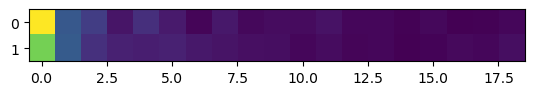

In [31]:
from matplotlib import pyplot as plt
# Create a new figure with the adjusted size and DPI
fig, ax = plt.subplots()

# Display the image array as a grayscale image
ax.imshow(np.stack((fs_non_syn, fs_syn)))

<Figure size 640x480 with 0 Axes>

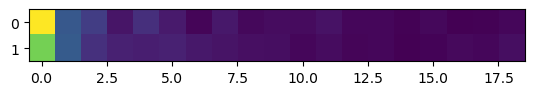

In [34]:
# display img after normalizing
afs_arr = np.stack((fs_non_syn, fs_syn))
norm = afs_arr / afs_arr.sum()

plt.clf()
fig, ax = plt.subplots()
ax.imshow(norm)

In [35]:
norm

array([[0.22717622, 0.0651097 , 0.04387827, 0.01627742, 0.03326256,
        0.01981599, 0.00636943, 0.01769285, 0.00849257, 0.01132343,
        0.009908  , 0.01415428, 0.00778485, 0.00778485, 0.004954  ,
        0.00849257, 0.00424628, 0.004954  , 0.00778485],
       [0.18046709, 0.06794055, 0.03467799, 0.02406228, 0.02264685,
        0.02406228, 0.01769285, 0.01556971, 0.01273885, 0.01203114,
        0.00707714, 0.01061571, 0.00636943, 0.00707714, 0.00353857,
        0.00566171, 0.00920028, 0.00707714, 0.01203114]])

In [42]:
a = np.array([1.2790565240624212,0.5316968778007666,0.035221079289616854,1.0670493405657722,
              0.20571877243569595,1.0398400908637655,4.345286469631841,1.6511054418096527,
              1.1183099082024603,7.193015482072557,0.4117626188555487,.24912296706570797,
              0.07998139501300965,0.010850650453046146])

In [43]:
a.round(3)

array([1.279, 0.532, 0.035, 1.067, 0.206, 1.04 , 4.345, 1.651, 1.118,
       7.193, 0.412, 0.249, 0.08 , 0.011])

In [45]:
round(-0.01567,3)

-0.016